#COMPARSION OF K-MEANS AND DBSCAN

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA

In [4]:
data = pd.read_csv("mall_customers.csv")
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [5]:
features = ["Age", "Gender", "Annual Income (k$)", "Spending Score (1-100)"]
X = data[features]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## Data Pre-Processing

In [9]:
# Remove rows where features have z-scores greater than a threshold (e.g., 3)
z_scores = np.abs(stats.zscore(X[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]))
X = X[(z_scores < 3).all(axis=1)]

# Check for missing values and handle them
X["Age"].fillna(X["Age"].mean(), inplace=True)
X["Annual Income (k$)"].fillna(X["Annual Income (k$)"].mean(), inplace=True)
X["Spending Score (1-100)"].fillna(X["Spending Score (1-100)"].mean(), inplace=True)

# Convert Age and Income to numeric
X["Age"] = pd.to_numeric(X["Age"], errors='coerce')
X["Annual Income (k$)"] = pd.to_numeric(X["Annual Income (k$)"], errors='coerce')

<ipython-input-9-7cb3b82e1011>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Age"].fillna(X["Age"].mean(), inplace=True)
<ipython-input-9-7cb3b82e1011>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [10]:
# One-hot encode "Gender"
X = pd.get_dummies(X, columns=["Gender"])

# Standardize features for K-means and DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Split data into training and testing sets (80%/20%)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

### K-means Clustering

In [12]:
# Determine the optimal number of clusters using silhouette score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

# Choose the number of clusters with the highest silhouette score
n_clusters = np.argmax(silhouette_scores) + 2

In [13]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_train)

train_labels_kmeans = kmeans.predict(X_train)

# Silhouette score for K-means
silhouette_avg_kmeans = silhouette_score(X_train, train_labels_kmeans)
print("K-means Silhouette score (training data):", silhouette_avg_kmeans)

K-means Silhouette score (training data): 0.4403920006525629


## DBSCAN Clustering

In [14]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_train)

train_labels_dbscan = dbscan.labels_

# Silhouette score for DBSCAN (only if there are more than one clusters)
if len(set(train_labels_dbscan)) > 1:
    silhouette_avg_dbscan = silhouette_score(X_train, train_labels_dbscan)
    print("DBSCAN Silhouette score (training data):", silhouette_avg_dbscan)
else:
    silhouette_avg_dbscan = -1  # Not applicable if DBSCAN fails to find clusters
    print("DBSCAN did not find more than one cluster")

DBSCAN Silhouette score (training data): -0.08959093565771122


## Visualization for both K-means and DBSCAN

In [16]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

Text(0, 0.5, 'Principal Component 2')

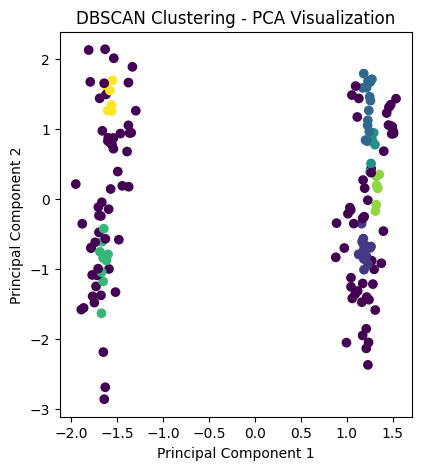

In [17]:
plt.figure(figsize=(10, 5))
# Plot for DBSCAN Clustering
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_labels_dbscan)
plt.title("DBSCAN Clustering - PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

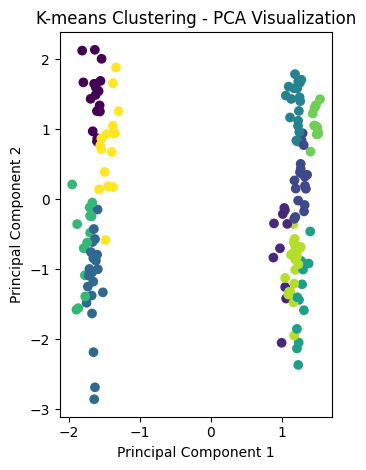

In [18]:
# Plot for K-means Clustering
plt.subplot(1, 2, 2)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_labels_kmeans)
plt.title("K-means Clustering - PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

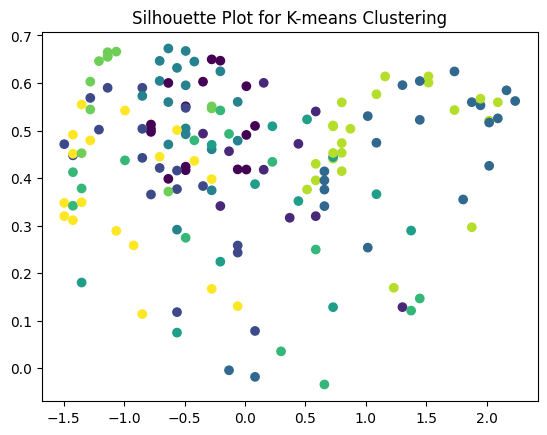

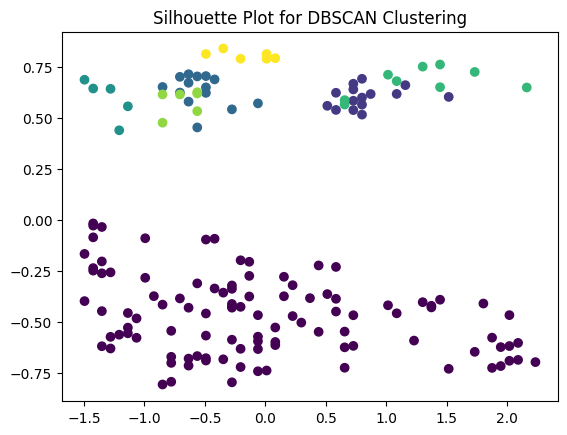

In [19]:
# ----- Silhouette Plot for K-means -----
silhouette_values_kmeans = silhouette_samples(X_train, train_labels_kmeans)
plt.scatter(X_train[:, 0], silhouette_values_kmeans, c=train_labels_kmeans)
plt.title("Silhouette Plot for K-means Clustering")
plt.show()

# ----- Silhouette Plot for DBSCAN -----
if len(set(train_labels_dbscan)) > 1:
    silhouette_values_dbscan = silhouette_samples(X_train, train_labels_dbscan)
    plt.scatter(X_train[:, 0], silhouette_values_dbscan, c=train_labels_dbscan)
    plt.title("Silhouette Plot for DBSCAN Clustering")
    plt.show()

In [20]:
# ----- Comparison of Algorithms -----
print("Comparison of Clustering Methods:")
print(f"K-means Silhouette Score: {silhouette_avg_kmeans}")
if silhouette_avg_dbscan != -1:
    print(f"DBSCAN Silhouette Score: {silhouette_avg_dbscan}")
else:
    print("DBSCAN did not find more than one cluster")


Comparison of Clustering Methods:
K-means Silhouette Score: 0.4403920006525629
DBSCAN Silhouette Score: -0.08959093565771122
